# Reading DICOM scans an saving as numpy arrays

In [22]:
import os
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

In [2]:
from lunglens.data import *

Microsoft Visual C++ Redistributable is not installed, this may lead to the DLL load failure.
                 It can be downloaded at https://aka.ms/vs/16/release/vc_redist.x64.exe


In [3]:
data_dir = Path('../data/extracted')
dest_root_dir = Path('../data/prepared')

## Kaggle: OSIC Pulmonary Fibrosis Progression

In [5]:
ds_dir = data_dir/'osic-pulmonary-fibrosis-progression'
dest_dir = dest_root_dir/'osic-pulmonary-fibrosis-progression/'

In [8]:
all_scans = list(ds_dir.rglob('ID0*'))

In [17]:
convert_dicoms2np(all_scans, dest_dir)

error occured when trying to save scan: ..\data\extracted\osic-pulmonary-fibrosis-progression\train\ID00052637202186188008618
Exception thrown in SimpleITK ImageSeriesReader_Execute: D:\a\1\sitk-build\ITK\Modules\IO\GDCM\src\itkGDCMImageIO.cxx:307:
itk::ERROR: itk::ERROR: GDCMImageIO(00000267A6396260): Failed to change to Implicit Transfer Syntax



In [19]:
all_files = list(dest_dir.glob('*/*.npy'))

scans_folders = [f.parent.name for f in all_files]

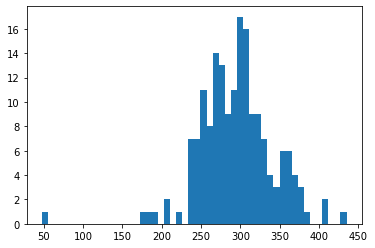

In [25]:
scan_sizes = list(Counter(scans_folders).values())

print_hist(np.array(scan_sizes))

## COVID19_1110 dataset

In [46]:
ds_dir = data_dir/'COVID19_1110'
dest_dir = dest_root_dir/'COVID19_1110'

In [47]:
all_files = list(ds_dir.rglob('*.nii'))

len(all_files)

1110

In [48]:
convert_dicoms2np(all_files, dest_dir)

In [48]:
??convert_dicoms2np

Signature: convert_dicoms2np(dicoms, dest_dir, target_voxel_mm=1.0)
Docstring: <no docstring>
Source:   
def convert_dicoms2np(dicoms, dest_dir, target_voxel_mm=cfg.TARGET_MM_PER_VX):
    for scan_f in tqdm(dicoms):
        scan_id = scan_f.stem if scan_f.is_file() else scan_f.name
        result_folder = dest_dir/f'{scan_id}'

#         if result_folder.exists():
#             continue

        try:
            # read dicom with default scaling
            reader = read_dicom_file if scan_f.is_file() else read_dicom_folder
            data, itk_image = reader(scan_f)

            # apply CT window for Lungs
            data = appply_window(data, normalize=True)

            # rescale to 1 mm per 1 vx
            data = rescale_dicom(itk_image, data, target_voxel_mm)

            os.makedirs(result_folder, exist_ok=True)

            # save each slice as numpy
            for slice_i, slice_data in enumerate(data):
                np.save(str(result_folder/f'{slice_i}.npy'), slice_data

## Kaggle: covid19-ct-scans

In [39]:
ds_dir = data_dir / 'covid19-ct-scans'
dest_dir = dest_root_dir / 'covid19-ct-scans'

(dest_dir / 'infected').mkdir(parents=True, exist_ok=True)
(dest_dir / 'healthy').mkdir(parents=True, exist_ok=True)

In [9]:
df = pd.read_csv(ds_dir / 'metadata.csv')
df[['ct_scan', 'infection_mask']].head()

,ct_scan,infection_mask
0,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/infection_mask/coron...
1,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/infection_mask/coron...
2,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/infection_mask/coron...
3,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/infection_mask/coron...
4,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/infection_mask/coron...


In [10]:
rel_path_exp = 'covid19-ct-scans/(.+)'
df['mask_path'] = df.infection_mask.str.extract(rel_path_exp)
df['scan_path'] = df.ct_scan.str.extract(rel_path_exp)

In [15]:
scan2mask = dict(zip(df.scan_path, df.mask_path))

In [49]:
for scan_id in tqdm(df.scan_path):
    scan_path = ds_dir / scan_id
    mask_path = ds_dir / scan2mask[scan_id]
    
    mask, _ = read_dicom_file(mask_path)
    scan, _ = read_dicom_file(scan_path)
    
    # apply lung CT window and normalize
    scan = appply_window(scan, normalize=True)
    
    infection_per_slice = mask.sum(axis=(1,2))
    for i, infection in enumerate(infection_per_slice):
        lbl = 'infected' if infection > 0 else 'healthy'
        
        slice_dest_path = dest_dir / lbl / f'{scan_path.stem}-{i:03}.npy'
        
        np.save(str(slice_dest_path), scan[i])